## DataObjects

This notebook discusses how py4DSTEM structures data.  It includes 3 sections:

1. The DataObjects
2. Searching DataObjects
3. Saving DataObjects

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import py4DSTEM

### Part 1: The DataObjects

In py4DSTEM there are several classes which contain distinct types of data, along with methods to easily interact with the data they contain.  The basic classes discussed here are:
1. DataCube
2. DiffactionSlice
3. RealSlice
4. PointList
5. PointListArray

In [2]:
# Import the DataObject classes

from py4DSTEM.file.datastructure import DataCube
from py4DSTEM.file.datastructure import DiffractionSlice, RealSlice
from py4DSTEM.file.datastructure import PointList, PointListArray

#### Datacube

The DataCube class contains four dimensional data, corresponding to a complete 4DSTEM dataset.
The shape of the data will be (R_Nx, R_Ny, Q_Nx, Q_Ny), where R_Ni is the number of real space scan positions in direction i, and Q_Ni is the number of detector pixels in direction i.

In [3]:
# Load data

fp = "/home/ben/Data/20180830_zeltman_smallsampledatasets/1_10x10 ss=100 alpha=p48 spot 11 cl=1200 300kV RT bin=4 0p5sec.dm3"
datacube = py4DSTEM.file.io.read(fp)

/home/ben/Data/20180830_zeltman_smallsampledatasets/1_10x10 ss=100 alpha=p48 spot 11 cl=1200 300kV RT bin=4 0p5sec.dm3 is not a py4DSTEM file.
Reading with hyperspy...


In [4]:
# fp = "/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180830_zeltman_smallsampledatasets/1_10x10 ss=100 alpha=p48 spot 11 cl=1200 300kV RT bin=4 0p5sec.dm3"
# datacube = py4DSTEM.file.io.read(fp)
# datacube.set_scan_shape(10,10)

In [5]:
# By default, reading a non-py4DSTEM file returns a DataCube. 

type(datacube)

py4DSTEM.file.datastructure.datacube.DataCube

In [6]:
# The most important attribute in a DataCube is data, which contains the 4D array of data itself

datacube.data

array([[[[23, 10,  0, ..., 17, 24,  5],
         [ 6,  0,  0, ..., 18,  6,  0],
         [ 0,  0, 26, ...,  5,  0,  0],
         ...,
         [ 0,  5,  0, ...,  5,  0,  9],
         [ 0,  0,  0, ...,  9,  0, 21],
         [27,  0, 11, ...,  0,  0, 17]]],


       [[[23, 12,  0, ..., 10,  1,  0],
         [ 1,  0,  0, ...,  0,  6,  0],
         [ 0,  0, 23, ...,  3,  0,  0],
         ...,
         [ 0,  3,  3, ...,  0,  0,  3],
         [ 7,  9,  0, ...,  2,  0, 23],
         [29,  0, 10, ...,  0,  0,  0]]],


       [[[20,  7, 12, ...,  0,  5,  9],
         [ 0,  0,  0, ..., 16,  5,  0],
         [ 0,  0, 13, ...,  3,  0,  0],
         ...,
         [ 0, 12,  1, ...,  3,  1, 17],
         [ 0, 18,  0, ...,  0,  0, 18],
         [38,  0,  0, ...,  0,  0, 13]]],


       ...,


       [[[21,  8, 11, ..., 10, 14,  3],
         [ 5,  0,  0, ..., 27,  4,  0],
         [ 1,  0, 25, ..., 11,  0,  0],
         ...,
         [ 0, 12, 11, ...,  6,  0,  9],
         [ 5, 15,  0, ..., 10,  0, 17]

In [7]:
# The shape of the data is accessible two ways
# Notice that the first two dimensions of the data are real space (R), and the last two are diffraction space (Q)

print(datacube.data.shape)
print(datacube.R_Nx, datacube.R_Ny, datacube.Q_Nx, datacube.Q_Ny)

(100, 1, 512, 512)
100 1 512 512


In [8]:
# Our data has a weird shape - in real space it looks like this was a 100x1 scan.  That hardly seems right!
# Note the warning message we got in the cell where we loaded the data:
# if the scan shape is not present or was not detected in the metadata, we need to set it manually
# We can do this easily by calling one of DataCube's methods

datacube.set_scan_shape(10,10)

In [9]:
# And now the data shape looks more reasonable!

print(datacube.data.shape)
print(datacube.R_Nx, datacube.R_Ny, datacube.Q_Nx, datacube.Q_Ny)

(10, 10, 512, 512)
10 10 512 512


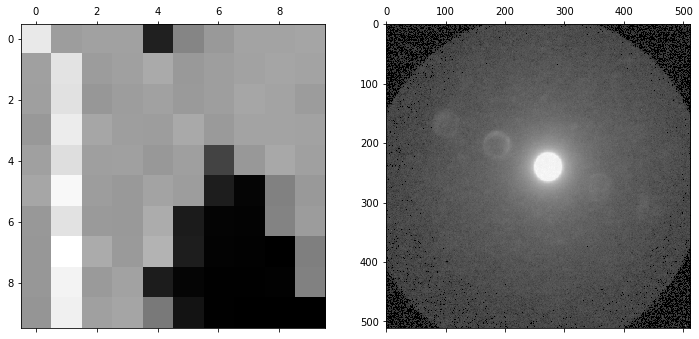

In [10]:
# Basic processing and display

# Get an average image: at each real-space scan position, add up all the counts in the associated diffraction
# pattern.  (i.e. a bright field image with a large integrating detector)
ave_im = np.sum(datacube.data,axis=(2,3))

# Get a single diffraction pattern from a particular beam position
DP = datacube.data[5,5,:,:]

# Display
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,6))
ax1.matshow(ave_im,cmap='gray')
ax2.matshow(DP**0.2,cmap='gray')
plt.show()

#### DiffractionSlice

The DiffractionSlice class contains data with shape (Q_Nx, Q_Ny).

In [11]:
# Let's make a simple example using a single diffraction pattern from datacube

DP = datacube.data[5,5,:,:]              # Get a diffraction pattern

diffractionslice = DiffractionSlice(DP)   # Make the DiffractionSlice

In [12]:
type(diffractionslice)    # Check the type

py4DSTEM.file.datastructure.diffraction.DiffractionSlice

In [13]:
diffractionslice.data   # The data lives in the attribute data

array([[30,  1,  6, ..., 10, 11,  0],
       [14,  0,  0, ...,  8,  4,  0],
       [ 0,  1, 25, ...,  0,  0,  0],
       ...,
       [ 0,  0, 13, ...,  0,  0,  6],
       [ 2, 17,  0, ..., 22,  0, 26],
       [28,  6,  0, ...,  0,  0,  4]], dtype=uint16)

In [14]:
# As for DataCubes, the shape can be accessed two ways

print(diffractionslice.data.shape)
print(diffractionslice.Q_Nx, diffractionslice.Q_Ny)

(512, 512)
512 512


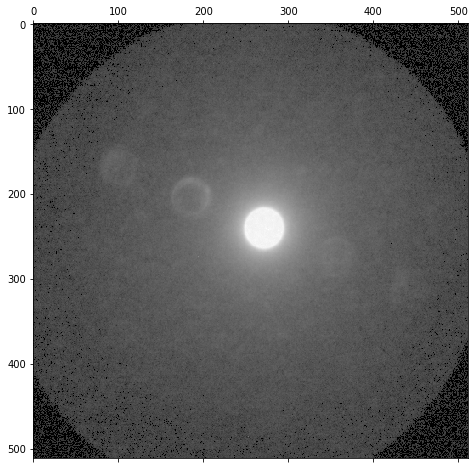

In [15]:
# Display

fig,ax=plt.subplots(figsize=(8,8))
ax.matshow(diffractionslice.data**0.2,cmap='gray')
plt.show()

In [16]:
# A single DiffractionSlice object can contain several slices
# We'll demonstrate a depth 3 DiffractionSlice here, containing three different diffraction patterns

scan_positions = ((1,5),(3,3),(8,7))   # Ordered pairs of scan positions (Rx,Ry) from which to extract DPs

DPs = np.empty((datacube.Q_Nx,datacube.Q_Ny,3)) # Initialize array for our data. Note that for DiffractionSlices 
                                                # with several slices, the expected shape for the data is
                                                #(Q_Nx, Q_Ny, depth)

for i in range(len(scan_positions)):
    x,y = scan_positions[i]
    DPs[:,:,i] = datacube.data[x,y,:,:]       # Grab diffraction patterns from the specified scan positions

diffractionslice_depth3 = DiffractionSlice(DPs,                     # Make the DiffractionSlice
                                           name="three_little_DPs") # Note that we can add names; this is helpful
                                                                    # later for searching and saving

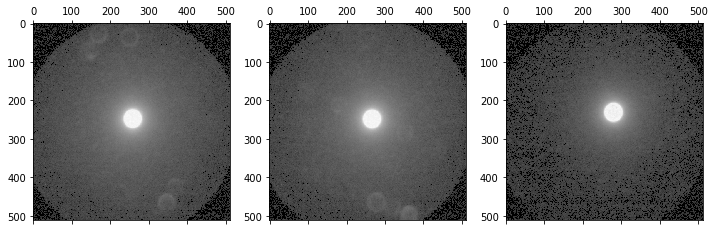

In [17]:
# Show

power=0.2

fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(12,6))
ax1.matshow(diffractionslice_depth3.data[:,:,0]**power)
ax2.matshow(diffractionslice_depth3.data[:,:,1]**power)
ax3.matshow(diffractionslice_depth3.data[:,:,2]**power)
plt.show()

#### RealSlice

The RealSlice class is essentially identical to DiffractionSlice, with the unsurprising difference that a RealSlice contains data with shape (R_Nx, R_Ny).

In [18]:
# We'll make a demo RealSlice using the average image from above

ave_im = np.sum(datacube.data,axis=(2,3))     # Sum over diffraction patterns at each Rx,Ry

realslice = RealSlice(ave_im, name='average_image')  # Make the RealSlice

In [19]:
type(realslice)    # Check the type

py4DSTEM.file.datastructure.real.RealSlice

In [20]:
realslice.data   # The data lives in the attribute data

array([[76860118, 67647893, 68196529, 68148053, 52668981, 64783152,
        67202742, 68518294, 68465883, 68669199],
       [68035784, 76168254, 67576549, 68029350, 69306583, 67206826,
        67815687, 68311567, 68712192, 68438909],
       [67915125, 75919307, 66910013, 67643970, 68115168, 67341420,
        67867952, 68717809, 68381147, 67596308],
       [67094913, 77159042, 68775082, 67844094, 67668829, 69117031,
        67283861, 68376650, 68477670, 68245215],
       [68087635, 75579729, 67967385, 68041759, 67120625, 67938994,
        56857899, 67071240, 68963321, 68009721],
       [68753690, 78708315, 67703555, 67188347, 68410913, 67645744,
        52276177, 49357164, 64262641, 67200310],
       [67040666, 76066281, 67348369, 67240445, 69447042, 52068548,
        49193722, 49095395, 64557745, 67530922],
       [66990406, 79566404, 69335737, 67299280, 70332715, 52290848,
        49073801, 48974177, 48704478, 64027984],
       [66997629, 78220191, 67357550, 68244810, 52142355, 493134

In [21]:
# Check the shape

print(realslice.data.shape)
print(realslice.R_Nx, realslice.R_Ny)

(10, 10)
10 10


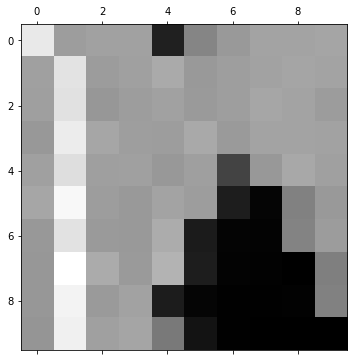

In [22]:
# Display

fig,ax=plt.subplots(figsize=(6,6))
ax.matshow(realslice.data,cmap='gray')
plt.show()

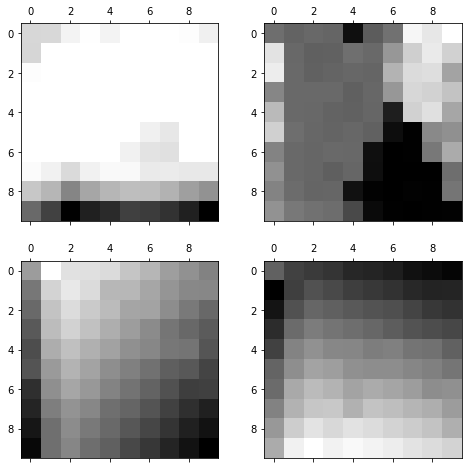

In [23]:
# RealSlice instances can also contain multiple slices
# Rather than referring to the slices of a RealSlice or DiffractionSlice objects by numerical indexes (as in
# the example above), we can instead give the slices names.
# Here, we'll make bright-field, annular dark field, and center of mass images.

# Set detector parameters
BF_R = 10
ADF_R_inner = 100
ADF_R_outer = 200
CoM_R = 200

# Get a guess for the position of the unscattered beam
aveDP = np.average(datacube.data,axis=(0,1))
x0,y0 = py4DSTEM.process.utils.get_CoM(aveDP)

# Get images
BF = datacube.get_virtual_image_circ_integrate(slice(int(x0)-BF_R,int(x0)+BF_R),    # These functions expects slice
                                               slice(int(y0)-BF_R,int(y0)+BF_R))[0] # objects, specifying the
                                                                                    # detector region
ADF = datacube.get_virtual_image_annular_integrate((slice(int(x0)-ADF_R_outer,int(x0)+ADF_R_outer)),
                                                   (slice(int(y0)-ADF_R_outer,int(y0)+ADF_R_outer)),
                                                    ADF_R_outer/ADF_R_inner)[0]
CoM_x = datacube.get_virtual_image_circ_CoMX((slice(int(x0)-CoM_R,int(x0)+CoM_R)),
                                                   (slice(int(y0)-CoM_R,int(y0)+CoM_R)))[0]
CoM_y = datacube.get_virtual_image_circ_CoMY((slice(int(x0)-CoM_R,int(x0)+CoM_R)),
                                                   (slice(int(y0)-CoM_R,int(y0)+CoM_R)))[0]

# Make RealSlice of images
data = np.empty((datacube.R_Nx,datacube.R_Ny,4))
data[:,:,0] = BF
data[:,:,1] = ADF
data[:,:,2] = CoM_x
data[:,:,3] = CoM_y

virtual_images = RealSlice(data, name='virtual_images',
                           slicelabels=('BF','ADF','CoM_x','CoM_y'))

fig,((ax11,ax12),(ax21,ax22)) = plt.subplots(2,2,figsize=(8,8))
ax11.matshow(virtual_images.slices['BF'])
ax12.matshow(virtual_images.slices['ADF'])
ax21.matshow(virtual_images.slices['CoM_x'])
ax22.matshow(virtual_images.slices['CoM_y'])
plt.show()

#### PointList

The PointList class is a flexible container for data which can be written as a set of points or vectors.
The coordinates of the points must be manually specified when the PointList is instantiated.  Data can be included on instantiation, or added (or deleted) later.

In [24]:
# Let's make a simple example specifying the 3 scan positions our diffraction patterns came from in the
# second DiffractionSlice example

scan_positions = ((0,4),(3,3),(8,7))   # Ordered pairs of scan positions (Rx,Ry) from which to extract DPs

coordinates = [('Rx',int), ('Ry',int)] # The coordinates for our example are scan positions, Rx,Ry
                                       # The syntax for specifying PointList coordinates is as a list of 2-tuples
                                       # containing the coordinate name (a string), and the coordinate datatype
        
pointlist = PointList(coordinates=coordinates)  # Instantiate the PointList

for (x,y) in scan_positions:
    pointlist.add_point((x,y))        # Add points to pointlist

In [25]:
type(pointlist)

py4DSTEM.file.datastructure.pointlist.PointList

In [34]:
# The data in a PointList a numpy structured array

pointlist.data

array([(0, 4), (3, 3), (8, 7)], dtype=[('Rx', '<i8'), ('Ry', '<i8')])

In [35]:
# The PointList keeps track of its own length

pointlist.length

3

In [36]:
# Access a specified coordinate

pointlist.data['Rx']

array([0, 3, 8])

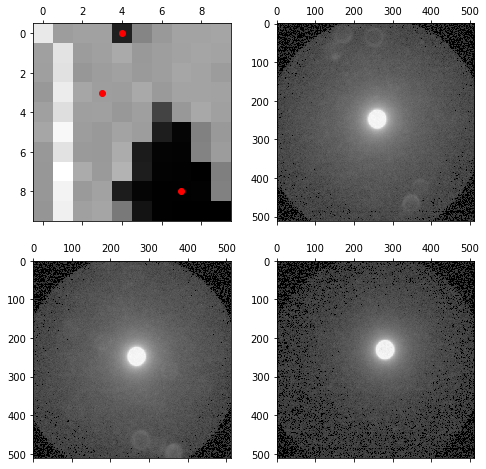

In [37]:
# We can now put together a few piece.  We'll display:
# -the average image
# -an overlay over the average image showing the selected scan positions
# -the three diffraction patterns corresponding to these scan positions

fig,((ax11,ax12),(ax21,ax22)) = plt.subplots(2,2,figsize=(8,8))
ax11.matshow(realslice.data)                                      # Show the average image
ax12.matshow(diffractionslice_depth3.data[:,:,0]**0.2)
ax21.matshow(diffractionslice_depth3.data[:,:,1]**0.2)                # Show the diffraction patterns
ax22.matshow(diffractionslice_depth3.data[:,:,2]**0.2)
ax11.scatter(pointlist.data['Ry'],pointlist.data['Rx'],color='r') # Overlay scan positions
plt.show()

In [30]:
# We can add points to an existing PointList; just be sure the order matches the coordinate order

pointlist.add_point((0,0))     # We can specify the new point as a tuple
pointlist.add_point([1,0])     # or as a list
pointlist.add_point([2,0])

In [31]:
# The length updates

pointlist.length

6

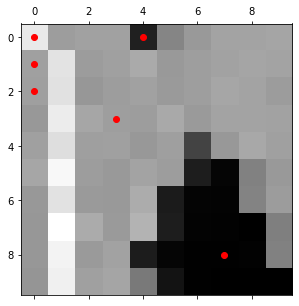

In [32]:
# Show the new pointlist overlaying the average image

fig,ax = plt.subplots(figsize=(5,5))
ax.matshow(realslice.data)                                        # Show the average image
ax.scatter(pointlist.data['Ry'],pointlist.data['Rx'],color='r')     # Overlay scan positions
plt.show()

In [33]:
# To remove points, we need to generaty a mask of boolean values with the same length as the pointlist.
# Wherever the mask==True, the point will be deleted by the PointList method remove_points(mask)
# Here, let's delete everything in the left hand column (y=0)

mask = (pointlist.data['Ry']==0)   # Make the mask

pointlist.remove_points(mask)      # Delete the specified point(s)

In [34]:
pointlist.length

3

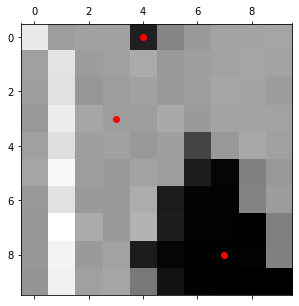

In [35]:
# Show

fig,ax = plt.subplots(figsize=(5,5))
ax.matshow(realslice.data)                                        # Show the average image
ax.scatter(pointlist.data['Ry'],pointlist.data['Rx'],color='r')     # Overlay scan positions
plt.show()

In [36]:
# We can add many points at once

points = np.hstack((np.expand_dims(np.arange(3),axis=1),
                    np.expand_dims(np.zeros(3),axis=1)))  # Make array of points
pointlist.add_unstructured_dataarray(points)              # Add points

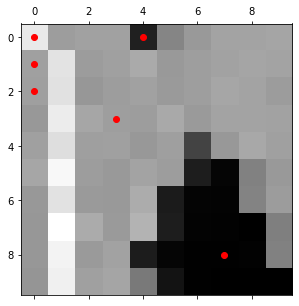

In [37]:
# Show

fig,ax = plt.subplots(figsize=(5,5))
ax.matshow(realslice.data)                                        # Show the average image
ax.scatter(pointlist.data['Ry'],pointlist.data['Rx'],color='r')     # Overlay scan positions
plt.show()

In [38]:
# PointLists can be sorted by any coordinate

pointlist.sort('Rx','descending')
pointlist.data

array([(8, 7), (3, 3), (2, 0), (1, 0), (0, 4), (0, 0)],
      dtype=[('Rx', '<i8'), ('Ry', '<i8')])

In [39]:
# We can copy pointlists

new_pointlist = pointlist.copy()

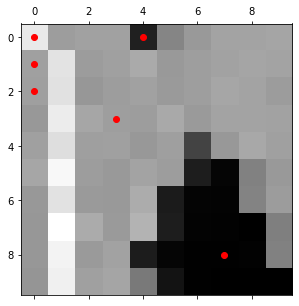

In [40]:
# Show

fig,ax = plt.subplots(figsize=(5,5))
ax.matshow(realslice.data)                                        # Show the average image
ax.scatter(new_pointlist.data['Ry'],new_pointlist.data['Rx'],color='r')     # Overlay scan positions
plt.show()

In [41]:
# We can also make a copy of a pointlist with additional coordinates added

new_coords = [('intensity',float),('ponies',int)]

extended_pointlist = pointlist.add_coordinates(new_coords=new_coords)

In [42]:
extended_pointlist.data

array([(8, 7, 0., 0), (3, 3, 0., 0), (2, 0, 0., 0), (1, 0, 0., 0),
       (0, 4, 0., 0), (0, 0, 0., 0)],
      dtype=[('Rx', '<i8'), ('Ry', '<i8'), ('intensity', '<f8'), ('ponies', '<i8')])

In [43]:
# Let's set the value of the new 'intensity' coordinate to the total integrated intensity of the DP
# at each scan position

for point in extended_pointlist.data:
    point['intensity'] = np.sum(datacube.data[point['Rx'],point['Ry'],:,:])
    point['ponies'] = 3

In [44]:
extended_pointlist.data

array([(8, 7, 48942321., 3), (3, 3, 67844094., 3), (2, 0, 67915125., 3),
       (1, 0, 68035784., 3), (0, 4, 52668981., 3), (0, 0, 76860118., 3)],
      dtype=[('Rx', '<i8'), ('Ry', '<i8'), ('intensity', '<f8'), ('ponies', '<i8')])

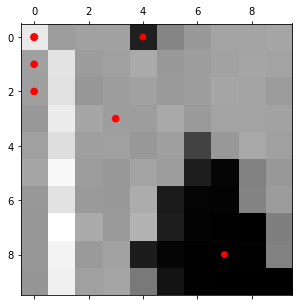

In [45]:
# Show the points, scaling their size by their intensity

fig,ax = plt.subplots(figsize=(5,5))
ax.matshow(realslice.data)                                                         # Show the average image
ax.scatter(extended_pointlist.data['Ry'],extended_pointlist.data['Rx'],color='r',
           s=50*extended_pointlist.data['intensity']/max(extended_pointlist.data['intensity'])) # Overlay points
plt.show()

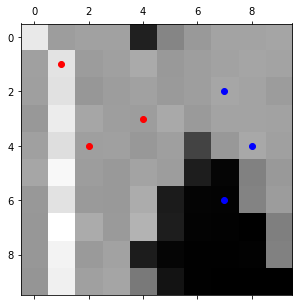

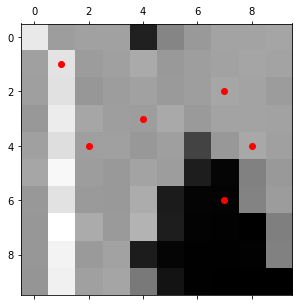

In [46]:
# We can also add a pointlist to a pointlist

# Make two pointlists
coordinates = [('Rx',int), ('Ry',int)]
points1 = ((1,1),(4,2),(3,4))
pointlist1 = PointList(coordinates=coordinates)
for (x,y) in points1:
    pointlist1.add_point((x,y))

points2 = ((2,7),(4,8),(6,7))
pointlist2 = PointList(coordinates=coordinates)
for (x,y) in points2:
    pointlist2.add_point((x,y))
    
# Show the two separate pointlists
fig,ax = plt.subplots(figsize=(5,5))
ax.matshow(realslice.data)                                         # Show the average image
ax.scatter(pointlist1.data['Ry'],pointlist1.data['Rx'],color='r')    # Overlay points1
ax.scatter(pointlist2.data['Ry'],pointlist2.data['Rx'],color='b')    # Overlay points2
plt.show()

# Add the pointlists
pointlist1.add_pointlist(pointlist2)

# Show
fig,ax = plt.subplots(figsize=(5,5))
ax.matshow(realslice.data)                                         # Show the average image
ax.scatter(pointlist1.data['Ry'],pointlist1.data['Rx'],color='r')    # Overlay points1
plt.show()

In [47]:
# We can also initialize a PointList from a tuple of ndarrays

x,y,z = np.arange(10), np.linspace(-1,1,10), np.zeros(10)
coords=[('x',int),('y',float),('z',int)]

pl = PointList(coordinates=coords, data=(x,y,z))
pl.data

array([(0, -1.        , 0), (1, -0.77777778, 0), (2, -0.55555556, 0),
       (3, -0.33333333, 0), (4, -0.11111111, 0), (5,  0.11111111, 0),
       (6,  0.33333333, 0), (7,  0.55555556, 0), (8,  0.77777778, 0),
       (9,  1.        , 0)],
      dtype=[('x', '<i8'), ('y', '<f8'), ('z', '<i8')])

#### PointListArray

The PointListArray class is a 2D array containing PointLists.  The primary use-case is when you need a pointlist at each scan position.  PointListArrays then enable quickly accessing each of these PointLists from memory.

In [38]:
# Let's make a PointListArray consisting of a handful of random points in each diffraction pattern.

coords = [('Qx',float),('Qy',float)]
shape = (datacube.R_Nx, datacube.R_Ny)

pointlistarray = PointListArray(coordinates=coords, shape=shape, name="random_points")

for Rx in range(datacube.R_Nx):
    for Ry in range(datacube.R_Ny):
        current_pointlist = pointlistarray.get_pointlist(Rx,Ry)
        for i in range(10):
            current_pointlist.add_point(np.random.random(2)*np.array([datacube.Q_Nx,datacube.Q_Ny]))

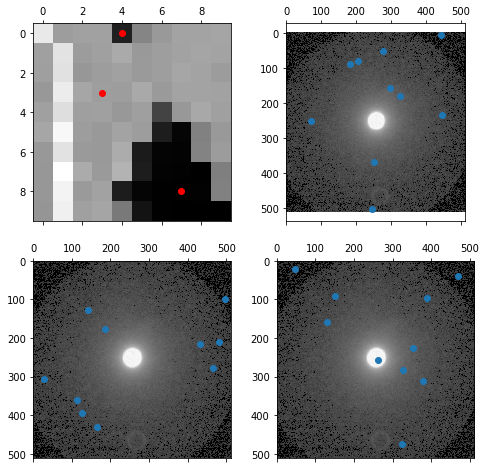

In [39]:
# Show the results for three diffraction patterns

Rxs = [0,3,8]
Rys = [4,3,7]

fig,((ax11,ax12),(ax21,ax22)) = plt.subplots(2,2,figsize=(8,8))
ax11.matshow(realslice.data)                          # Show the average image
ax11.scatter(Rys, Rxs,color='r')                        # Overlay scan positions
ax12.matshow(datacube.data[Rxs[0],Rys[0],:,:]**0.2)
ax21.matshow(datacube.data[Rxs[0],Rys[0],:,:]**0.2)   # Show the diffraction patterns
ax22.matshow(datacube.data[Rxs[0],Rys[0],:,:]**0.2)
ax12.scatter(pointlistarray.get_pointlist(Rxs[0],Rys[0]).data['Qx'],
             pointlistarray.get_pointlist(Rxs[0],Rys[0]).data['Qy'])
ax21.scatter(pointlistarray.get_pointlist(Rxs[1],Rys[1]).data['Qx'],   # Show the PointListArray random points
             pointlistarray.get_pointlist(Rxs[1],Rys[1]).data['Qy'])
ax22.scatter(pointlistarray.get_pointlist(Rxs[2],Rys[2]).data['Qx'],
             pointlistarray.get_pointlist(Rxs[2],Rys[2]).data['Qy'])
plt.show()

In [50]:
# As for PointLists, we can make copies, or make copies with additional coordinates

new_coords = [('intensity',float),('ponies',int)]

extended_pointlistarray = pointlistarray.add_coordinates(new_coords=new_coords)

In [51]:
# Populate the 'intensity' field with the diffraction space intensity at that point

for Rx in range(datacube.R_Nx):
    for Ry in range(datacube.R_Ny):
        curr_pointlist = extended_pointlistarray.get_pointlist(Rx,Ry)
        for point in curr_pointlist.data:
            point['intensity'] = datacube.data[Rx,Ry,int(point['Qx']),int(point['Qy'])]
            point['ponies'] = 14

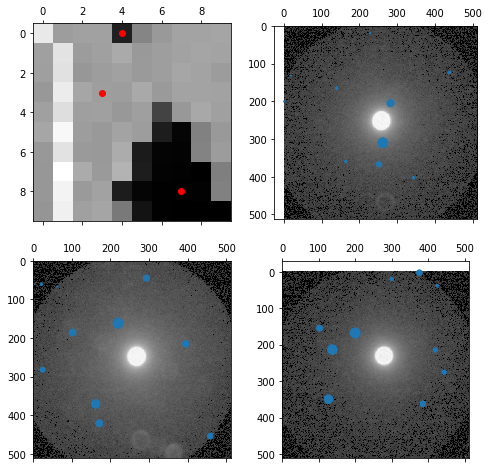

In [52]:
# Show the results, scaling the dot sizes by the diffracted intensity

size_scale = 100

Rxs = [0,3,8]
Rys = [4,3,7]

fig,((ax11,ax12),(ax21,ax22)) = plt.subplots(2,2,figsize=(8,8))
ax11.matshow(realslice.data)                          # Show the average image
ax11.scatter(Rys, Rxs,color='r')                        # Overlay scan positions
ax12.matshow(datacube.data[Rxs[0],Rys[0],:,:]**0.2)
ax21.matshow(datacube.data[Rxs[1],Rys[1],:,:]**0.2)   # Show the diffraction patterns
ax22.matshow(datacube.data[Rxs[2],Rys[2],:,:]**0.2)
pointlist12 = extended_pointlistarray.get_pointlist(Rxs[0],Rys[0])
pointlist21 = extended_pointlistarray.get_pointlist(Rxs[1],Rys[1])   # Get the relavant pointlists
pointlist22 = extended_pointlistarray.get_pointlist(Rxs[2],Rys[2])
ax12.scatter(pointlist12.data['Qx'],pointlist12.data['Qy'],
             s=size_scale*pointlist12.data['intensity']/max(pointlist12.data['intensity']))
ax21.scatter(pointlist21.data['Qx'],pointlist21.data['Qy'],
             s=size_scale*pointlist21.data['intensity']/max(pointlist21.data['intensity']))
ax22.scatter(pointlist22.data['Qx'],pointlist22.data['Qy'],
             s=size_scale*pointlist22.data['intensity']/max(pointlist22.data['intensity']))
plt.show()

#### Metadata stuff

In [59]:
# Sort the data objects by type

DataObject.sort_dataobjects_by_type(show=True)

 Index                  Name                        Type        
   0                                        Metadata            
   1                                        DataCube            
   2                                        DiffractionSlice    
   3    three_little_DPs                    DiffractionSlice    
   4    average_image                       RealSlice           
   5    virtual_images                      RealSlice           
   6                                        PointList           
   7                                        PointList           
   8                                        PointList           
   9    random_points                       PointListArray      
   10                                       PointListArray      


In [60]:
DataObject.get_dataobject_by_index(3)

In [61]:
metadata = DataObject.get_dataobject_by_index(0)

In [62]:
DataObject.get_dataobjects()

In [63]:
diffslice1 = DiffractionSlice(data=np.zeros((datacube.Q_Nx,datacube.Q_Ny)),metadata=metadata)
diffslice2 = DiffractionSlice(data=np.zeros((datacube.Q_Nx,datacube.Q_Ny)),metadata=diffslice1)
realslice1 = RealSlice(data=np.zeros((datacube.R_Nx,datacube.R_Ny)),metadata=datacube)
realslice2 = RealSlice(data=np.zeros((datacube.R_Nx,datacube.R_Ny)),metadata='randomstring')

In [64]:
metadata.original_metadata.shortlist

├── Acquisition_instrument
│   └── TEM
│       ├── acquisition_mode = TEM
│       ├── beam_current = 0.005
│       ├── beam_energy = 300.0
│       ├── camera_length = 195.0
│       ├── magnification = 1200.0
│       └── microscope = FEI Tecnai Remote
├── General
│   ├── date = 2018-06-11
│   ├── original_filename = 1_10x10 ss=100 alpha=p48 spot 11 cl=1200 300kV RT bin=4 0p5sec.dm3
│   ├── time = 16:22:54
│   └── title = 1_10x10 ss=100 alpha=p48 spot 11 cl=1200 300kV RT bin=4 0p5sec
└── Signal
    ├── Noise_properties
    │   └── Variance_linear_model
    │       ├── gain_factor = 1.0
    │       └── gain_offset = 0.0
    ├── binned = False
    ├── quantity = Intensity
    └── signal_type = 

In [67]:
len(pointlist.dtype.names)

2

In [66]:
md=[]
dataobjs = [diffslice1, diffslice2, realslice1, realslice2]

for do in dataobjs:
    if do.metadata is not None and do.metadata not in md:
        md.append(do.metadata)

In [67]:
md

In [68]:
raise Exception('nooope')

Exception: nooope

In [69]:
[x for x in np.arange(10) if x>5]

[6, 7, 8, 9]

In [70]:
DataObject.get_dataobject_list()

[[0,
  '',
  py4DSTEM.process.datastructure.metadata.Metadata,
 [1,
  '',
  py4DSTEM.process.datastructure.datacube.DataCube,
 [2,
  '',
  py4DSTEM.process.datastructure.diffraction.DiffractionSlice,
 [3,
  'three_little_DPs',
  py4DSTEM.process.datastructure.diffraction.DiffractionSlice,
 [4,
  'average_image',
  py4DSTEM.process.datastructure.real.RealSlice,
 [5,
  'virtual_images',
  py4DSTEM.process.datastructure.real.RealSlice,
 [6,
  '',
  py4DSTEM.process.datastructure.pointlist.PointList,
 [7,
  '',
  py4DSTEM.process.datastructure.pointlist.PointList,
 [8,
  '',
  py4DSTEM.process.datastructure.pointlist.PointList,
 [9,
  'random_points',
  py4DSTEM.process.datastructure.pointlist.PointListArray,
 [10,
  '',
  py4DSTEM.process.datastructure.pointlist.PointListArray,
 [11,
  '',
  py4DSTEM.process.datastructure.diffraction.DiffractionSlice,
 [12,
  '',
  py4DSTEM.process.datastructure.diffraction.DiffractionSlice,
 [13,
  '',
  py4DSTEM.process.datastructure.real.RealSlice,
 [1

In [61]:
import h5py

In [62]:
fp="/home/ben/Desktop/test1.h5"
f = h5py.File(fp)

In [ ]:
list(f['4DSTEM_experiment']['data']['realslices']['average_image'].keys())

In [ ]:
np.array(f['4DSTEM_experiment']['data']['realslices']['virtual_images']['ADF'])

In [ ]:
list(f['4DSTEM_experiment']['log'].keys())

In [60]:
f['4DSTEM_experiment']['log']['log_item_4']['inputs'].attrs['dataobject_list']

NameError: name 'f' is not defined

In [83]:
list(f['4DSTEM_experiment']['metadata']['original']['shortlist']['Signal'].attrs)

['binned', 'quantity', 'signal_type']

In [85]:
f['4DSTEM_experiment']['metadata']['original']['shortlist']['Signal'].attrs['binned']

False

In [92]:
list(f['4DSTEM_experiment']['metadata']['microscope'].attrs.keys())

['accelerating_voltage',
 'accelerating_voltage_units',
 'camera_length',
 'camera_length_units',
 'C2_aperture',
 'convergence_semiangle_mrad',
 'spot_size',
 'scan_rotation_degrees',
 'dwell_time',
 'dwell_time_units',
 'scan_size_Ny',
 'scan_size_Nx',
 'R_pix_size',
 'R_pix_units',
 'K_pix_size',
 'K_pix_units',
 'probe_FWHM_nm',
 'acquisition_date',
 'original_filename']

In [63]:
list(f['4DSTEM_experiment']['data']['pointlists'].keys())

['pointlist_0', 'pointlist_1', 'pointlist_2']

In [64]:
list(f['4DSTEM_experiment']['data']['pointlists']['pointlist_0'].attrs)

['coordinates', 'dimensions', 'length']

In [65]:
f['4DSTEM_experiment']['data']['pointlists']['pointlist_0'].attrs['length']

6

In [99]:
list(f['4DSTEM_experiment']['data']['pointlists']['pointlist_0']['Rx'].attrs)

['dtype']

In [101]:
f['4DSTEM_experiment']['data']['pointlists']['pointlist_0']['Rx'].attrs['dtype']

b'int64'

In [108]:
f['4DSTEM_experiment']['data']['pointlists']['pointlist_0']['Rx']['data']

<HDF5 dataset "data": shape (6,), type "<i8">

In [87]:
f['4DSTEM_experiment']['data']['pointlistarrays']['random_points']['0_1']

<HDF5 group "/4DSTEM_experiment/data/pointlistarrays/random_points/0_1" (2 members)>

In [82]:
isinstance([datacube],list)

True

In [53]:
import hyperspy.api_nogui as hs

In [54]:
data = hs.load('sdlkjfs')

ValueError: No file name matches this pattern